In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# prepare object points
nx = 9# enter the number of inside corners in x
ny = 6# enter the number of inside corners in y

objp  = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

In [ ]:
objp.shape

In [ ]:
import matplotlib.pyplot as plt
import glob
import cv2
import pickle


objpoints =[]
imgpoints =[]
print ( " .. starting  ")

plt.axis('off')
i = 0
for fname in glob.glob("./camera_cal/*"):
#     print (name)\
    img = cv2.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        objpoints.append(objp)
        imgpoints.append(corners )


    i += 1
    plt.axis('off')
#     plt.imshow(img)
#     plt.show()

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )    
print ( " .. completed .. saved into wide_dist_pickle.p  ")

## Creating test images from the videos

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

class save_images ( object ):
    def __init__( self ):
        self.i = 0
    def __call__( self, image):
        # do something
        self.i +=1
        cv2.imwrite("test_images2/image" + str(self.i) + ".jpg", cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        return image
    
save_images = save_images()    
    
## creating additional test images
from moviepy.editor import VideoFileClip
output_video_name = 'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
clip2 = clip1.subclip(0,2)
output_video = clip2.fl_image(save_images) #NOTE: this function expects color images!!

%time output_video.write_videofile(output_video_name, audio=False)






[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 60/60 [00:03<00:00, 11.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 2.26 s, sys: 270 ms, total: 2.53 s
Wall time: 5.16 s


In [3]:
class save_images ( object ):
    def __init__( self ):
        self.i = 0
    def __call__( self, image):
        # do something
        self.i +=1
        cv2.imwrite("test_images3/image" + str(self.i) + ".jpg", cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        return image
    
save_images = save_images()    
    
## creating additional test images
from moviepy.editor import VideoFileClip
output_video_name = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_video = clip1.fl_image(save_images) #NOTE: this function expects color images!!

%time output_video.write_videofile(output_video_name, audio=False)



[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  3%|▎         | 32/1261 [00:01<01:12, 16.86it/s]

KeyboardInterrupt: 

## Working on test image
### Reading test image and undistorting it

In [4]:
import cv2

test_image = cv2.imread("test_images3/image577.jpg")
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

In [5]:
import matplotlib.pyplot as plt
import glob
import cv2
import pickle
import numpy as np
# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
print ( " mtx.shape = " + str(mtx.shape) )

undst = cv2.undistort(test_image, mtx, dist, None, mtx)
undst = np.copy(test_image)

 mtx.shape = (3, 3)


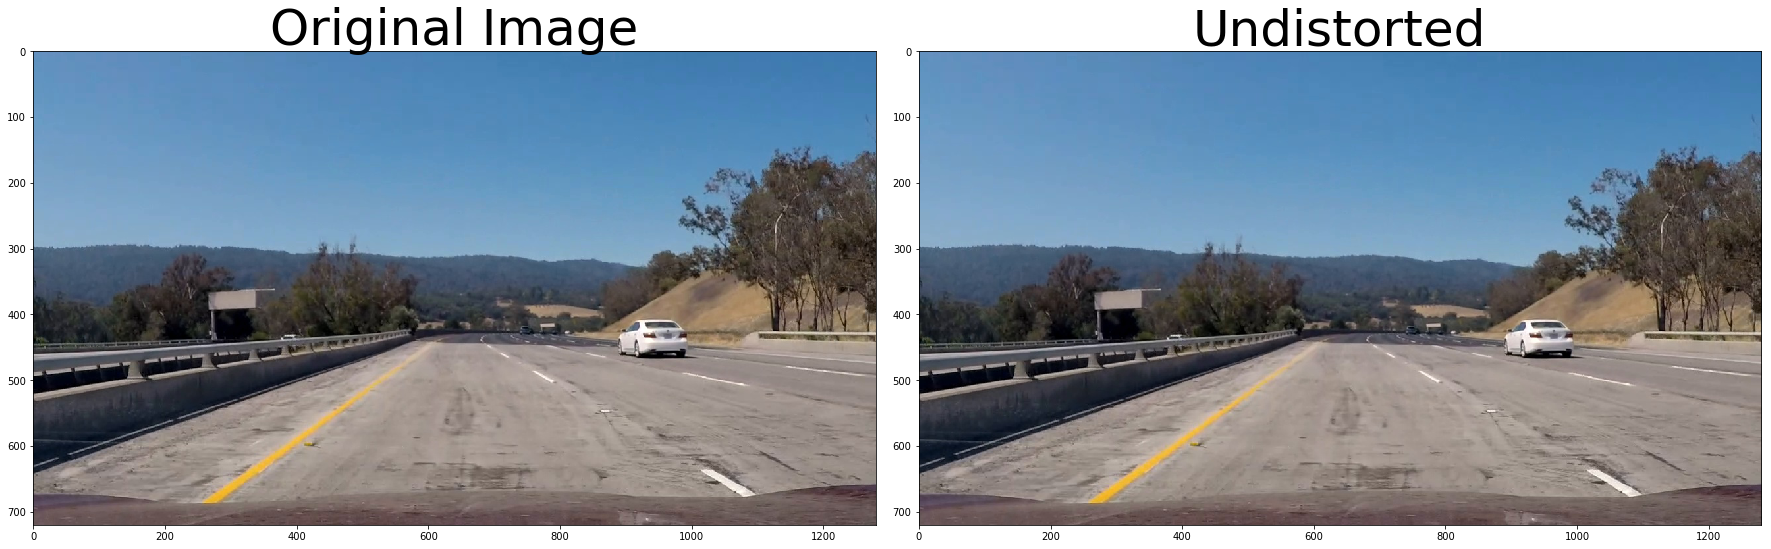

In [6]:
# top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(undst)
ax2.set_title('Undistorted', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### experimenting thresholds
#### Soebel X on the gray image

In [7]:
gray = cv2.cvtColor(undst, cv2.COLOR_RGB2GRAY)

In [8]:
# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 25
thresh_max = 110
soebelx_binary = np.zeros_like(scaled_sobel)
soebelx_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1



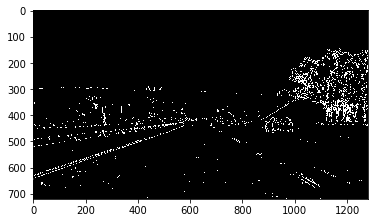

In [9]:
temp = np.dstack(( soebelx_binary, soebelx_binary, soebelx_binary)) * 255

plt.imshow(temp)
plt.show()

In [10]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=15, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

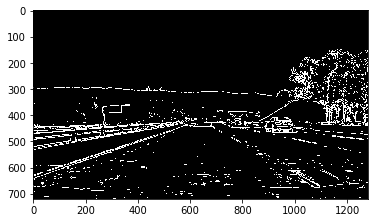

In [11]:
mag_binary = mag_thresh(undst, sobel_kernel=3, mag_thresh=(30, 255))
temp = np.dstack((mag_binary,mag_binary,mag_binary))*255
plt.imshow(temp)
plt.show()

In [12]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

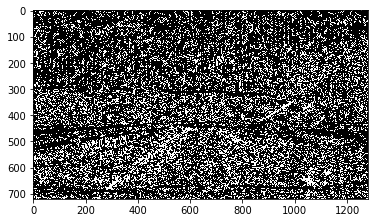

In [13]:
dir_binary = dir_threshold(undst, sobel_kernel=15, thresh=(0.7,1.2))
temp = np.dstack((dir_binary,dir_binary,dir_binary)) #*255
plt.imshow(temp)
plt.show()

### Choosing the best HLS channel

In [14]:
# Convert to HLS color space and separate the V channel
hls = cv2.cvtColor(undst, cv2.COLOR_RGB2HLS).astype(np.float)
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]
h_channel_color = np.dstack((h_channel, h_channel, h_channel)) #*255
l_channel_color = np.dstack((l_channel, l_channel, l_channel)) #*255
s_channel_color = np.dstack((s_channel, s_channel, s_channel)) #*255

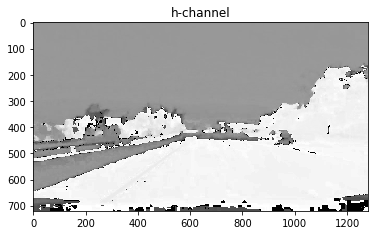

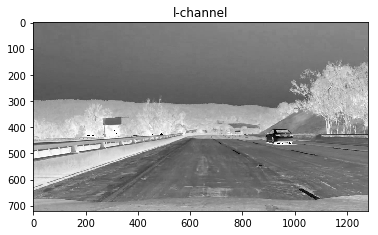

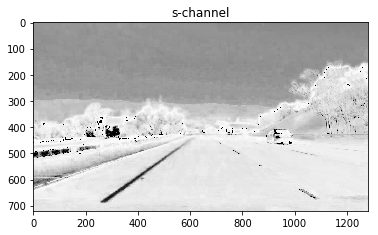

In [15]:
plt.imshow(h_channel_color, cmap="gray")
plt.title ("h-channel")
plt.show()

plt.imshow(l_channel_color, cmap="gray")
plt.title ("l-channel")
plt.show()

plt.imshow(s_channel_color, cmap="gray")
plt.title ("s-channel")
plt.show()



### S-channel Threshold

In [16]:
def hls_select(img, thresh=(0, 255),channel = "s"):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if channel == "s":
        channel = hls[:,:,2]
    elif channel =="h":        
        channel = hls[:,:,0]
    elif channel =="l":        
        channel = hls[:,:,1]
    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary_output

In [17]:
s_binary = hls_select(undst,thresh=(100, 220),channel="s")


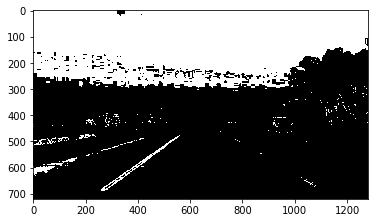

In [18]:
temp = np.dstack((s_binary,s_binary,s_binary)) *255
plt.imshow(temp,cmap="gray")
plt.show()

#### combining together s-channel threshold and soebel x 

In [19]:
# Merge the images. Based on lots of trial and error
combined = np.zeros_like(dir_binary)
combined[((s_binary == 1))|((dir_binary == 1)&(mag_binary == 1))] = 1

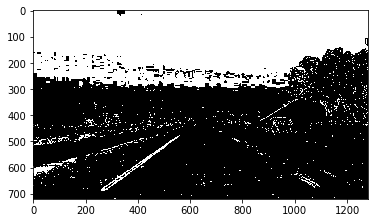

In [20]:
plt.imshow(combined, cmap="gray")

plt.show()

### Changing the perspective

In [21]:
x_len = undst.shape[1]
y_len = undst.shape[0]

#######    
## calculate the source points for image warp ( bird eyes view )
#######    
src_top_left     = [int(0.4353125*x_len),int(0.65*y_len)]
src_top_right    = [int(0.5778125*x_len),int(0.65*y_len)]

src_bottom_left  = [int(0.19171875*x_len),y_len]
src_bottom_right = [int(0.92*x_len),y_len]

src_corners = np.float32([src_top_left,
                      src_top_right,
                      src_bottom_right,
                      src_bottom_left])

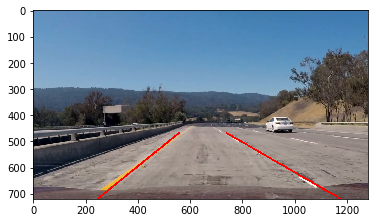

In [22]:
def draw_poly (img, src_corners):
    img_draw = np.copy(img)
#     print ( src_corners[0][0])
#     print (src_corners[0][1])
    cv2.line(img_draw,tuple(src_corners[0]),
                      tuple(src_corners[3]),
                       (255,0,0),5)

    cv2.line(img_draw,tuple(src_corners[1]),
                      tuple(src_corners[2]),
                       (255,0,0),5)

    return img_draw
drawed_poly = draw_poly(np.copy(undst), src_corners)
plt.imshow(drawed_poly)
plt.show()

In [23]:
def bird_eyes (image , src_corners, dst_corners) :
    
    M = cv2.getPerspectiveTransform(src_corners, dst_corners)
    Minv = cv2.getPerspectiveTransform(dst_corners, src_corners)
    warped = cv2.warpPerspective(image, M, ( image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

    return warped, M, Minv


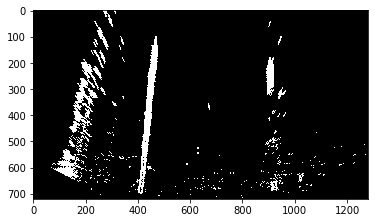

In [24]:
#######    
## calculate the destination points for image warp ( bird eyes view )
#######    
dst_bottom_left = [int(.33*x_len),y_len] 
dst_bottom_right = [int(0.725*x_len), y_len]

dst_top_left = [int(.345*x_len), 1]
dst_top_right = [int(0.71875*x_len), 1]

dst_corners = np.float32([dst_top_left,
                          dst_top_right,
                          dst_bottom_right, 
                          dst_bottom_left
                         ])


warped , M, Minv = bird_eyes(combined,src_corners, dst_corners)
warped[warped > 0 ] = 1
plt.imshow(warped,cmap="gray")
plt.show()


  3%|▎         | 32/1261 [00:20<12:50,  1.59it/s]

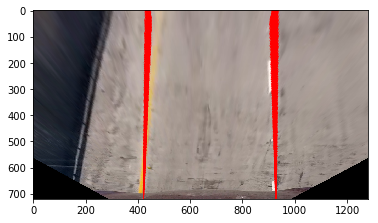

In [25]:
warped_drawed , M_drawed, Minv_drawed = bird_eyes(drawed_poly,src_corners, dst_corners)
plt.imshow(warped_drawed)
plt.show()


In [26]:
def remove_edge_pixels(img, thresh=75):
    shape=img.shape
    w=shape[1]
    h=shape[0]
    # left
    cv2.rectangle(img,(0,0),(thresh,h),(0,0,0),thresh)
    #right
    cv2.rectangle(img,(w-thresh,0),(w,h),(0,0,0),thresh)
    return img

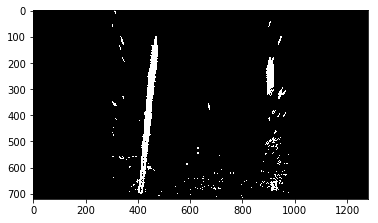

In [27]:
warped_cutted = remove_edge_pixels(warped,thresh=200)
plt.imshow(warped_cutted,cmap="gray")
plt.show()

### defining Pipeline function

In [28]:
# Edit this function to create your own pipeline.
def pipeline(input_img, s_thresh=(140, 255), sx_thresh=(140, 255)):

    # Threshold magnitude
    mag_binary = mag_thresh(input_img, sobel_kernel=3, mag_thresh=(30, 255))

    ####
    # Direction threshold
    ####
    dir_binary = dir_threshold(input_img, sobel_kernel=15, thresh=(0.7,1.2))

    ####
    # hls threshold
    ####
    s_binary = hls_select(input_img,thresh=(100, 220))

    # Merge the images. Based on lots of trial and error
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[((s_binary == 1))|((dir_binary == 1)&(mag_binary == 1))] = 1

   
    return combined_binary,  mag_binary , dir_binary, s_binary

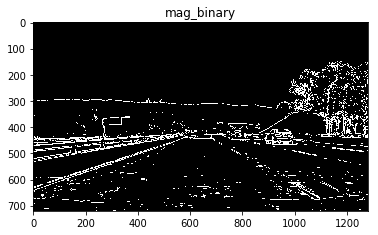

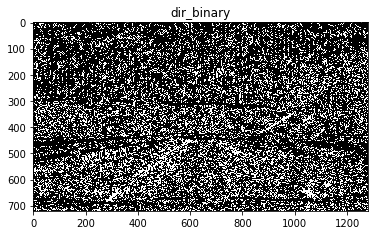

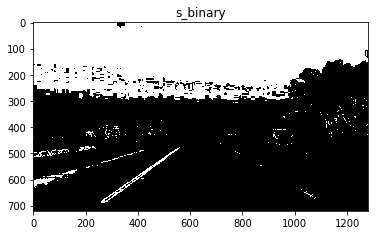

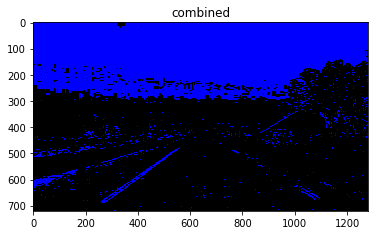

In [29]:
pipelined , mag_binary , dir_binary, s_binary = pipeline(undst)

temp = np.dstack((mag_binary,mag_binary,mag_binary))*255
plt.imshow(temp, cmap="gray")
plt.title ("mag_binary")
plt.show()

temp = np.dstack((dir_binary,dir_binary,dir_binary)) #*255
plt.imshow(temp, cmap="gray")
plt.title ("dir_binary")
plt.show()

temp = np.dstack((s_binary,s_binary,s_binary))*255
plt.imshow(temp, cmap="gray")
plt.title ("s_binary")
plt.show()

pipelined_color = np.dstack((np.zeros_like(pipelined),np.zeros_like(pipelined),pipelined)) #*255
plt.imshow(pipelined_color)
plt.title ("combined")
plt.show()




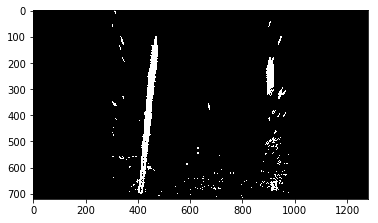

In [30]:
warped , M, Minv = bird_eyes(combined,src_corners, dst_corners)
warped[warped > 0 ] = 1
warped_cutted = remove_edge_pixels(warped,thresh=200)
plt.imshow(warped_cutted, cmap="gray")
plt.show()

# Line Finding Method: Peaks in a Histogram

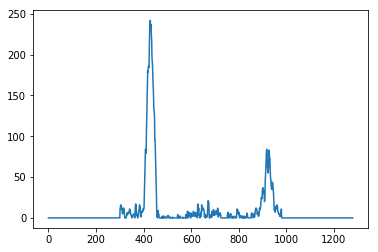

In [31]:
import numpy as np
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

In [32]:
pipelined[pipelined > 1]

array([], dtype=float64)

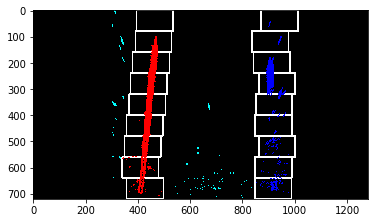

In [33]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def histogram_lane_find(input_image):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(input_image[input_image.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((np.zeros_like(input_image), input_image, input_image)) 
#     out_img = np.copy(input_image)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
#     print ( "midpoint = " + str(midpoint ))
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
#     print ( "leftx_base = " + str(leftx_base ))
#     print ( "rightx_base = " + str(rightx_base ))

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(input_image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = input_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 70
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
#         print ("window" )
        # Identify window boundaries in x and y (and right and left)
        win_y_low = input_image.shape[0] - (window+1)*window_height
        win_y_high = input_image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        
#         print ( "win_xleft_low = " + str(win_xleft_low))
#         print ( "win_y_low = " + str(win_y_low))
#         print ( "win_xleft_high = " + str(win_xleft_high))
#         print ( "win_y_high = " + str(win_y_high))
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (1,1,1), 4) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (1,1,1), 5) 
#         plt.imshow(out_img,cmap="gray")
#         plt.show()
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

#     out_img = np.zeros_like(out_img)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0 ]

    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]

    return  out_img , left_fit , right_fit

out_img , left_fit , right_fit= histogram_lane_find (warped_cutted)
# # Fit a second order polynomial to each

plt.imshow(out_img)
plt.show()



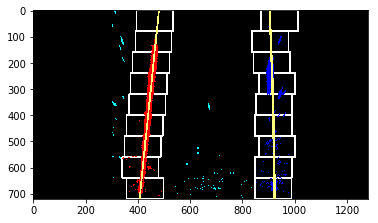

In [34]:
def draw_polyfit( input_image, left_fitx, right_fitx):
    temp = np.copy(input_image)

    for y, x  in enumerate(left_fitx):
        if x > 0 and x <  input_image.shape[1]:
            yellow = [1,1,.5]
            temp[y,int(x) ] = yellow
            if x < temp.shape[1] - 5:
                temp[y,int(x) +1 ] = yellow
                temp[y,int(x) +2 ] = yellow
                temp[y,int(x) +3 ] = yellow
                temp[y,int(x) +4 ] = yellow
            if x > 5:    
                temp[y,int(x) -1 ] = yellow
                temp[y,int(x) -2 ] = yellow

    for y, x  in enumerate(right_fitx):
        if x > 0 and x <  input_image.shape[1]:
            yellow = [1,1,.5]
            temp[y,int(x) ] = yellow
            if x < temp.shape[1] - 5:
                temp[y,int(x) +1 ] = yellow
                temp[y,int(x) +2 ] = yellow
                temp[y,int(x) +3 ] = yellow
                temp[y,int(x) +4 ] = yellow
            if x > 5:    
                temp[y,int(x) -1 ] = yellow
                temp[y,int(x) -2 ] = yellow
                temp[y,int(x) -3 ] = yellow
                temp[y,int(x) -4 ] = yellow

    return temp

# Generate x and y values for plotting
ploty = np.linspace(0, undst.shape[0]-1, undst.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
plt.imshow(draw_polyfit(out_img, left_fitx, right_fitx))
plt.show()

In [35]:
temp.shape[1]

1280

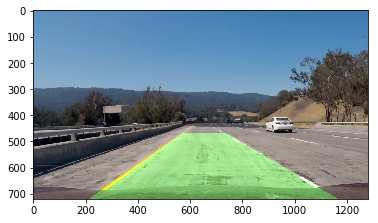

In [36]:
def draw_area_and_warpback(ori_undst_img ,left_fitx, right_fitx, Minv ):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(ori_undst_img).astype(np.uint8)
#     color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, ori_undst_img.shape[0]-1, ori_undst_img.shape[0] )
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(warp_zero, Minv, (ori_undst_img.shape[1], ori_undst_img.shape[0])) 
    # Combine the result with the original image
    result = newwarp
    result = cv2.addWeighted(ori_undst_img, 1, newwarp, 0.3, 0)
    
    return result

plt.imshow(draw_area_and_warpback(undst,left_fitx, right_fitx, Minv))
# plt.imshow(warped)
plt.show()

In [37]:
warped.shape

(720, 1280)

In [38]:
temp = warped*255
temp[temp>0]

array([ 255.,  255.,  255., ...,  255.,  255.,  255.])

## Working on the video

In [96]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.i  = 0

        #polynomial coefficients for the most last 3 fits
        self._last_fits = []  
        
        #radius of previous curvature calculated of last 3 fits 
        self._previous_radius =[]

        self.ym_per_pix = 30/720
        self.xm_per_pix = 3.7/700 

        self.ploty = np.linspace(0, undst.shape[0]-1, undst.shape[0] )
        self.y_eval = np.max(ploty)
        
        # the radius of the actual frame ( that can be eventually discared)
        self._actual_radius = None
        
        self.perc_diff_radius = None
        
        self.text = ""
        
    @property
    def previous_radius_mean(self):
        if not self._previous_radius :  ## testing if the array of last 3 fits is empty
            return self._actual_radius
        else:
            return np.mean(self.previous_radius)
        
    @property
    def last_fits(self):
        return self._last_fits
    
    @last_fits.setter
    def last_fits(self,fit):
        self._last_fits.append(fit)
        ### keeping only the last 3 fits
        self._last_fits = self._last_fits[-3:]

    @property 
    def previous_radius(self):
        return self._previous_radius
    
    @previous_radius.setter
    def previous_radius(self, radius):
        self._previous_radius.append(radius)
        ### keeping only the last 3 radius
        self._previous_radius = left_line.previous_radius[-3:]
        
    @property
    def average_fit(self):
        ### calculating the average on last 3 fits
        return np.mean(self._last_fits,axis=0)      

    def add_fit(self, input_fit):
        self.text = ""
        
        self._actual_radius = ((1 + (2*input_fit[0]*self.y_eval*self.ym_per_pix \
                                 + input_fit[1])**2)**1.5) \
                                 / np.absolute(2*input_fit[0])

#         print ( "w_actual_radius" + str(w_actual_radius))
#         print ( "self.previous_radius_mean" + str(self.previous_radius_mean))
#         print ( "self.previous_radius_mean" + str(self.previous_radius_mean))
        ### the first frame doesnt have the previous radius
        if self.previous_radius_mean: 
            self.perc_diff_radius = abs(self._actual_radius - self.previous_radius_mean) / self.previous_radius_mean*100
        else:
            self.perc_diff_radius = 0
            
        ### adding the current fit only in case of % difference less than a specific %
        if self.perc_diff_radius  < 65:
            ## calling the class setter to add the current_fit to the fit history
            self.last_fits     = input_fit
            self.previous_radius  = self._actual_radius
        else:
            print ("discarded" )
            self.text = "discarded actual {} %".format(self.perc_diff_radius)
        


In [97]:
left_line = Line()
right_line = Line()

left_line.previous_fit = [1,1,1]

In [98]:
def draw_processing_inlay(final, out_img, text, lay_number, left_or_right_pos) :
        # Add the processing window. Shows Histogram fitting errors
        font = cv2.FONT_HERSHEY_SIMPLEX
#         fit_errors = "L: {:0.4f}  R: {:0.4f}".format(np.sum(left_line.current_fit_error**2),np.sum(right_line.current_fit_error**2))
    
        if out_img is None:
            if left_or_right_pos == "left":
                x_offset =  20
            else:
                x_offset = final.shape[1]- 330

            y_offset = 55 + 40* (lay_number - 1)
            final = cv2.putText(final,text,(x_offset,y_offset), font, .5,(255,255,255),1,lineType = cv2.LINE_AA)
        else:
            if left_or_right_pos == "left":
                x_offset =  20
            else:
                x_offset = final.shape[1]- 230

            y_offset = 25 + 150* (lay_number - 1)
            out_img = cv2.resize(out_img,(int(320*.6),int(240*.6)))
            out_img = cv2.putText(out_img,text,(10,30), font, .5,(255,255,255),1,lineType = cv2.LINE_AA)
            final[y_offset:y_offset+out_img.shape[0], x_offset:x_offset+out_img.shape[1]] = out_img

            final[y_offset:y_offset+out_img.shape[0], x_offset:x_offset+out_img.shape[1]] = out_img
            
        return final

In [99]:
from PIL import Image
import math

def process_image(input_img):
#     print ("*")
#     print ("******* START ")
#     print ("*")

    #######    
    ## undistort the image based on previous Camera Calibration
    #######
    undst = cv2.undistort(input_img, mtx, dist, None, mtx)

#     undst = cv2.GaussianBlur(undst, (3, 3), 0)

    #######    
    ## determine the image dimension 
    #######
    x_len = input_img.shape [1]
    y_len = input_img.shape [0]
    
    #######    
    ## calculate the source points for image warp ( bird eyes view )
    #######    
    src_top_left     = [int(0.4453125*x_len),int(0.62*y_len)]
    src_top_right    = [int(0.5278125*x_len),int(0.62*y_len)]

    src_bottom_left  = [int(0.19171875*x_len),y_len]
    src_bottom_right = [int(0.92*x_len),y_len]

    src_corners = np.float32([src_top_left,
                          src_top_right,
                          src_bottom_right,
                          src_bottom_left])
    

    #######    
    ## calculate the destination points for image warp ( bird eyes view )
    #######    
    dst_bottom_left = [int(.33*x_len),y_len] 
    dst_bottom_right = [int(0.725*x_len), y_len]

    dst_top_left = [int(.345*x_len), 1]
    dst_top_right = [int(0.71875*x_len), 1]

    dst_corners = np.float32([dst_top_left,
                              dst_top_right,
                              dst_bottom_right, 
                              dst_bottom_left
                             ])

    #######    
    ## Combined Thresholds
    #######    
    combined_thresholds_binary , mag_binary , dir_binary, s_binary = pipeline(undst)

    #######    
    ## bird eyes ( perspective transform ) using the undistorted image 
    #####
    bird_eyes_img, M, Minv = bird_eyes( combined_thresholds_binary, src_corners, dst_corners)    
    
    # the combined_thresholds_binary was binary but the warp bird eyes will change the value of the pixels
    ## so I reset to 1 max value 
    bird_eyes_img[bird_eyes_img > 0 ] = 1

    # cut off areas of non interest = left & right side
    bird_eyes_img = remove_edge_pixels(bird_eyes_img,thresh=200)

    ## Bird eyes for poly draw on the undistorted image
    drawed_poly = draw_poly(undst, src_corners )
    bird_eyes_img_draw, M_draw, Minv_draw = bird_eyes( drawed_poly, src_corners, dst_corners)    
    
    # cut off areas of non interest = left & right side
    bird_eyes_img_draw = remove_edge_pixels(bird_eyes_img_draw,thresh=200)
    
    #######    
    ## sliding window using histogram
    #######    
    
    out_img_histo , left_fit , right_fit= histogram_lane_find (bird_eyes_img)

    left_line.add_fit(left_fit)
    right_line.add_fit(right_fit)

    # Generate x and y values for plotting
    left_fitx = left_line.average_fit[0]*ploty**2 +\
                left_line.average_fit[1]*ploty    +\
                left_line.average_fit[2]
            
    right_fitx = right_line.average_fit[0]*ploty**2 +\
                 right_line.average_fit[1]*ploty    +\
                 right_line.average_fit[2]
    
    out_img_histo_poly = draw_polyfit(out_img_histo, left_fitx, right_fitx)

    final = draw_area_and_warpback(undst,left_fitx, right_fitx,Minv )

    #######    
    ## insert a box inside of the original image with the bird eyes view 
    #######    
    temp = np.dstack((bird_eyes_img,bird_eyes_img,bird_eyes_img)) * 255
    final = draw_processing_inlay(final, temp, "Bird Eyes", 1, "left")   

    temp = out_img_histo_poly*255
    final = draw_processing_inlay(final, temp , "Poly", 2, "left")   

#     combined_thresholds_color = np.dstack((combined_thresholds_binary,\
#                                            combined_thresholds_binary,\
#                                            combined_thresholds_binary))*255
#     final = draw_processing_inlay(final,combined_thresholds_color, "Combined thresholds", 3, "left")   

    text = "left actual_radius  = "+str(int(left_line._actual_radius ))  #+ "\n {} %".format(left_radius_diff)
    final = draw_processing_inlay(final,None, text, 1, "right")   

    text = "left previous radius avg "+str(int(left_line.previous_radius_mean )) #+ "\n {} %".format(right_radius_diff)
    final = draw_processing_inlay(final,None, text, 2, "right")   
    
    text = "left % difference radius  "+str(int(left_line.perc_diff_radius )) #+ "\n {} %".format(right_radius_diff)
    final = draw_processing_inlay(final,None, text, 3, "right")   

    text = "RIGHT actual_radius  = "+str(int(right_line._actual_radius ))  #+ "\n {} %".format(left_radius_diff)
    final = draw_processing_inlay(final,None, text, 5, "right")   

    text = "RIGHT previous radius avg "+str(int(right_line.previous_radius_mean )) #+ "\n {} %".format(right_radius_diff)
    final = draw_processing_inlay(final,None, text, 6, "right")   
    
    text = "RIGHT % difference radius  "+str(int(right_line.perc_diff_radius )) #+ "\n {} %".format(right_radius_diff)
    final = draw_processing_inlay(final,None, text, 7, "right")   


    text = "left text = " + left_line.text
    final = draw_processing_inlay(final,None, text, 8, "right")   

    text = "right text = " + right_line.text
    final = draw_processing_inlay(final,None, text, 9, "right")   

    

    
    left_line.i += 1
    cv2.imwrite("temp/final" +str(left_line.i) + ".jpg", final)
    return final

In [100]:
left_line = Line()
right_line = Line()


from moviepy.editor import VideoFileClip
output_video_name = 'project_video_output2.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip2 = clip1.subclip(0,22)
output_video = clip2.fl_image(process_image) #NOTE: this function expects color images!!

%time output_video.write_videofile(output_video_name, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video project_video_output2.mp4
[MoviePy] Writing video project_video_output2.mp4


  1%|          | 4/551 [00:01<03:48,  2.39it/s]

KeyboardInterrupt: 

In [ ]:
a = [1,2,3,4]
a  = a[-3:]
a


In [ ]:
clip1.reader.close()
clip1.audio.reader.close_proc()

In [ ]:
left_line.current_fit[0]

In [ ]:
diff

In [ ]:
np.linspace(0, 719, 720)

# Measuring Curvature

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

print ("leftx.shape {}".format(leftx.shape))
print ("rightx.shape {}".format(rightx.shape))
leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel
positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images
plt.show()

In [ ]:
left_fit

In [ ]:
leftx.shape

In [ ]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

In [ ]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

In [ ]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (test_image.shape[1], test_image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undst, 1, newwarp, 0.3, 0)
plt.imshow(color_warp)
plt.show()

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None